In [1]:
%cd /home/smalani/Cybernetic/growthcurvefit/alldatacsv/
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from tqdm import tqdm
import os

/home/smalani/Cybernetic/growthcurvefit/alldatacsv


In [21]:
def monod(t, pars):
    mumax, Ks, Y = pars
    def odefun(t, x):
        S, X = x
        mu = mumax * S / (Ks + S)
        dSdt = -mu * X / Y
        dXdt = mu * X
        return [dSdt, dXdt]

    S0 = 2
    x0 = 0.01
    sol = solve_ivp(odefun, [t[0], t[-1]], [S0, x0], t_eval=t)
    return sol.y[1]

def baranyifun(t_arr, p):

    # Parameters
    x0, mu_max, xmax, lambd = p

    y0 = np.log(x0)
    ymax = np.log(xmax)

    A = t_arr + (1/mu_max) * np.log(np.exp(-mu_max * t_arr) + np.exp(-mu_max * lambd) - np.exp(-mu_max * t_arr -mu_max * lambd))

    y_t = y0 + mu_max * A - np.log(1 + (np.exp(mu_max * A) - 1) / (np.exp(ymax - y0)))
    x_t = np.exp(y_t)

    return x_t

def fsolvefun(pars, df, label):
    mumax, Ks, Y = pars
    x0 = 0.01
    pars = mumax, Ks, Y

    t_arr = df['Time'].iloc[:df[label].size].to_numpy()
    x_t = monod(t_arr, pars)
    error = np.mean((x_t - df[label]) ** 2)

    return error# + (xmax - 10) * 10

Aug29_SGy136.csv
Jul20 - SGy128-3 - Lights.csv
Sep1_SGy103-13.csv
Sep6_SGy104-4_SGy104-5.csv
Sep9_TempVar.csv
Aug10 - SGy136 - SC.csv
Aug12 - SGy136 Minimal.csv
Aug16_SGy103-10_SGy103-16.csv
Aug24_SGy103-10.csv
OptoQINVRT4-PDC1-SGy104-1.csv
OptoQAMP1-PDC1-SGy128-4.csv
OptoQINVRT4-PDC1-SGy104-6.csv
OptoQAMP2-PDC1-SGy103-12.csv
Empty DataFrame
Columns: [Filename, Column, mu_max, xmax, lambd]
Index: []
[0.11853766 0.01153711 5.57937379]
0.4044245232257606
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Empty DataFrame
Columns: [Filename, Column, mu_max, xmax, lambd]
Index: []
[  4.931406   129.54400232   4.        ]
0.032537688761989335
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Empty DataFrame
Columns: [Filename, Column, mu_max, xmax, lambd]
Index: []
[0.12241556 0.00726474 5.66288828]
0.49916742945128706
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Empty DataFrame
Columns: [Filename, Column, mu_max, xmax, lambd]
Index: []
[0.11940169 0.02595704 4.15128802]
0.05385137417454085
CO

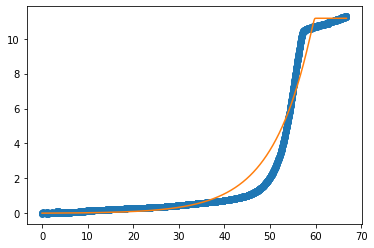

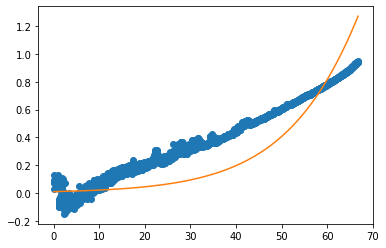

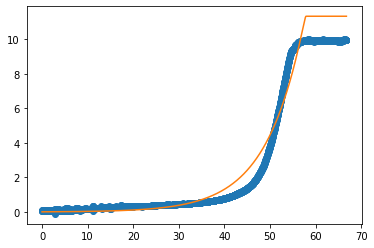

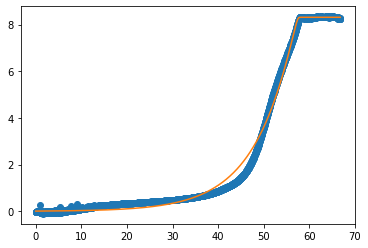

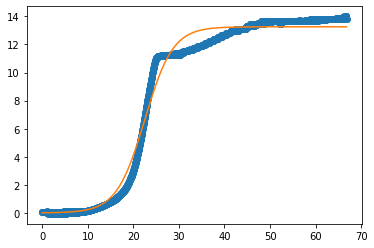

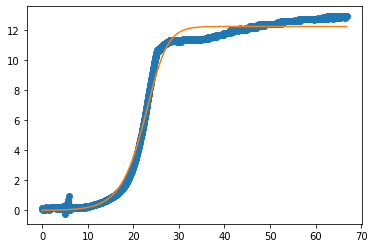

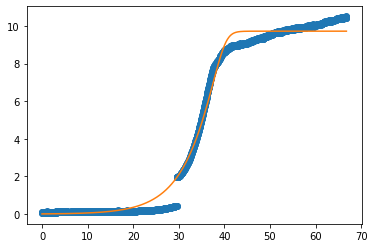

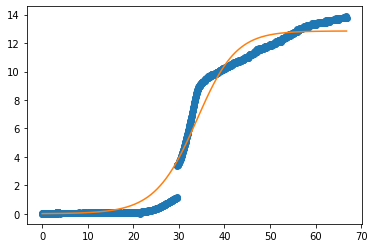

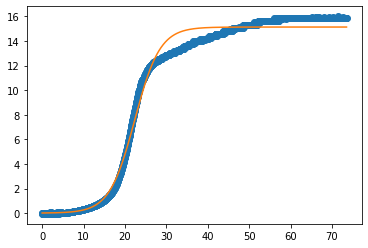

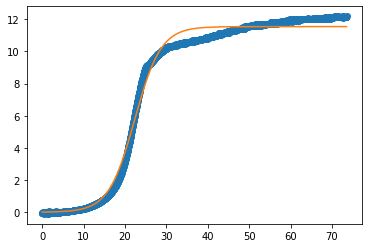

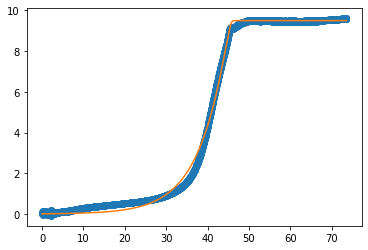

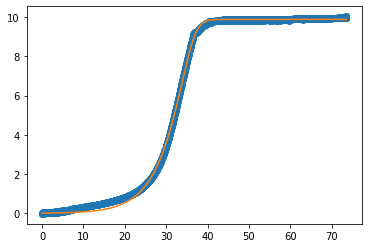

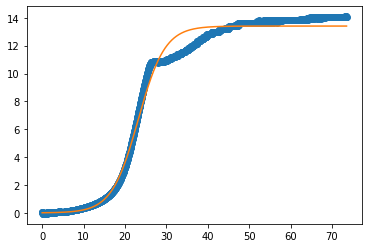

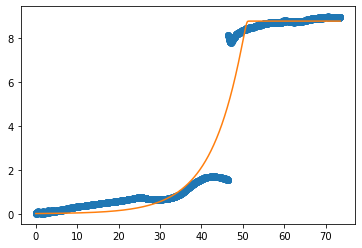

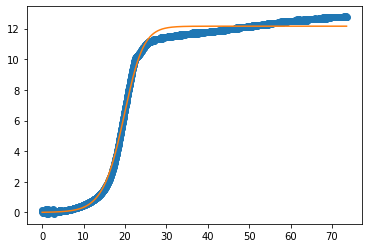

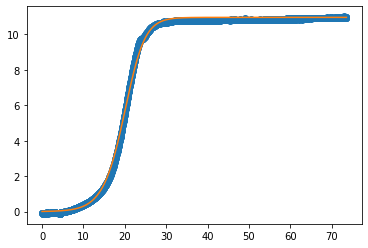

In [24]:
import glob
path = "/home/smalani/Cybernetic/growthcurvefit/alldatacsv/*.csv"

fsolve_guess = np.array([0.8, 10, 10])
bounds = tuple([(1e-10, None), (0, None), (4, 8)])

mu_xls = pd.DataFrame(columns=['Filename',
        'Column',
        'mu_max',
        'xmax',
        'lambd'])

mu_list = []

for fname in glob.glob(path):
    filename = os.path.basename(fname)
    print(filename)

    if "103-12" not in filename:
        continue
    df = pd.read_csv(fname)
    column_names = df.columns[1:]
    for column in column_names:
        fsolve_sol = minimize(fsolvefun, fsolve_guess, args=(df[['Time',column]],column ), method='L-BFGS-B', \
            bounds=bounds, options={'eps': 1e-9, 'maxls': 1000, 'gtol': 1e-15, 'ftol': 1e-15})
        mu0 = fsolve_sol.x[0] * 2 / (2 + fsolve_sol.x[1])
        mu_list.append({'Filename': filename, 'Column': column, 'mu_max': fsolve_sol.x[0], \
            'Ks': fsolve_sol.x[1], 'Y': fsolve_sol.x[2], 'mu0': mu0})

        if "103-12" in filename:
            print(mu_xls)

            print(fsolve_sol.x)
            print(fsolve_sol.fun)
            print(fsolve_sol.message)

            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.plot(df['Time'], df[column], 'o', label='Data')

            mumax, Ks, Y = fsolve_sol.x
            pars = mumax, Ks, Y
            
            ax.plot(df['Time'], monod(df['Time'].to_numpy(), pars), label='Fit')

            # assert False

# savefilename =  "/home/smalani/Cybernetic/growthcurvefit/alldatacsv/results_monod.xlsx"
# df = pd.DataFrame.from_records(mu_list)
# df.to_excel(savefilename, sheet_name='sheet1', index=False)